In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import json
import os
import feather
from pandas.io.json import json_normalize
from functools import partial
from pdb import set_trace

from datetime import datetime, timedelta
import urllib.request

from fastai2.vision.all import *
from fastai2.tabular.all import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
url = URLs.MNIST
path = untar_data(url)

In [4]:
class PILImageBWNoised(PILImageBW): pass
class TensorImageBWNoised(TensorImageBW): pass
PILImageBWNoised._tensor_cls = TensorImageBWNoised

class PILImageTarget(PILImageBW): pass
class TensorImageTarget(TensorImageBW): pass
PILImageTarget._tensor_cls = TensorImageTarget

@Normalize
def encodes(self, to:TensorImageTarget): return to

class AddNoiseTransform(Transform):
    "Add noise to image"
    order = 11
    def __init__(self, noise_factor=0.5): store_attr(self, 'noise_factor')
    def encodes(self, o:TensorImageBWNoised): return (o + (self.noise_factor * torch.randn(*o.shape).to(o.device))).clamp(0,1)

mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBWNoised), CategoryBlock, ImageBlock(cls=PILImageTarget)), 
                 get_items=get_image_files,
                 get_x= [noop, parent_label],
                 splitter=GrandparentSplitter(train_name='training' if url == URLs.MNIST else 'train', valid_name='testing' if url == URLs.MNIST else 'valid'),
                 batch_tfms=[AddNoiseTransform(.3), Normalize()],
                 n_inp=2)

In [5]:
dls = mnist.dataloaders(path, num_workers=0, bs=128)

In [6]:
class UnFlatten(Module):
    def __init__(self, size): self.size = size
    def forward(self, input):
        return input.view(input.size(0), self.size, 7, 7)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        kernel_size = 2
        self.encoder = nn.Sequential(
            ResBlock(1, 1, 16, act_cls=Swish),
            nn.MaxPool2d(2, 2),
            ResBlock(1, 16, 4, act_cls=Swish),
            nn.MaxPool2d(2, 2),
            Flatten()
        )
        
        self.emb = Embedding(10, emb_sz_rule(10))
        
        h_dim = h_dim + emb_sz_rule(10)
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim-emb_sz_rule(10))
        self.fc4 = nn.Linear(emb_sz_rule(10), 7*7)
        
        self.decoder = nn.Sequential(
            ResBlock(1, 5, 8, ks=1, act_cls=Swish),
            nn.Upsample(scale_factor=2),
            ResBlock(1, 8, 16, act_cls=Swish),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.cuda.HalfTensor(*mu.size()).normal_()
#         esp = torch.randn(*mu.size()).to(mu.device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, num):
        h = self.encoder(x)
        e = self.emb(num)
        h = torch.cat([h,e], dim=1)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z, num):
        z = self.fc3(z)
        z = z.view(z.size(0), 4, 7, 7)
        
        num = self.fc4(self.emb(num)).view(z.size(0), 1, 7, 7)
        z = torch.cat([z, num], dim=1)
        
        z = self.decoder(z)
        return z

    def forward(self, x, num):
        num = num.long()
        z, mu, logvar = self.encode(x, num)
        z = self.decode(z, num)
        return z, mu, logvar
    
    def inference(self, n=1, c=None):

        batch_size = n
        z = torch.randn([batch_size, self.latent_size])

        recon_x = self.decoder(z, c)

        return recon_x
    
model = VAE(image_channels=1, h_dim=196, z_dim=128).cuda()

In [7]:
class Concat(Module):
    def __init__(self, dim):
        self.dim
    def forward(self, tensors):
        return torch.cat(tensors, dim=self.dim)

class FastVAE(Module):
    def __init__(self, img_channels=3, z_dim=64):
        self.body = create_body(resnet18, n_in=img_channels)
        h_dim = num_features_model(self.body)
        
        self.z_dim = z_dim
        
        self.emb = Embedding(10, emb_sz_rule(10))
        
        self.encoder = nn.Sequential(*[self.body, nn.AdaptiveAvgPool2d(1), Flatten()])
        
        h_dim = h_dim + emb_sz_rule(10)
        
        self.fc_mu = nn.Linear(h_dim, z_dim)
        self.fc_logvar = nn.Linear(h_dim, z_dim)
        self.fc_z_to_channel = nn.Linear(z_dim, 4*7*7)
        self.fc_emb_to_channel = nn.Linear(emb_sz_rule(10), 1*7*7)
        
        self.decoder = nn.Sequential(
            nn.Conv2d(4+1, 4, 1),
            Swish(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(4, 16, 3, padding=1),
            Swish(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.fc = nn.ModuleList([self.fc_mu, self.fc_logvar, self.fc_z_to_channel, self.fc_emb_to_channel, self.decoder])
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.cuda.HalfTensor(*mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, num):
        h = self.encoder(x)
        e = self.emb(num)
        h = torch.cat([h,e], dim=1)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z, num):
        z = self.fc_z_to_channel(z)
        z = z.view(z.size(0), 4, 7, 7)
        
        num = self.fc_emb_to_channel(self.emb(num)).view(z.size(0), 1, 7, 7)
        z = torch.cat([z, num], dim=1)
        
#         t = self.adapt(z)
#         print(t.shape)
        z = self.decoder(z)
        return z

    def forward(self, x, num):
        num = num.long()
#         padding = x.new(x.size(0), 2, x.size(2), x.size(3))
#         x = torch.cat((x, padding), 1)
        z, mu, logvar = self.encode(x, num)
        z = self.decode(z, num)
        return z, mu, logvar
    
# model = FastVAE(img_channels=3, z_dim=64).cuda()

In [8]:
img, num, targets = dls.one_batch()

In [9]:
# %debug
with torch.no_grad():
    res = model(img, num)

In [10]:
class BCEMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        self.preds.append(F.binary_cross_entropy(to_detach(learn.pred[0]), to_detach(learn.y), reduction='sum'))
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class KLDMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        pred, mu, logvar, _ = to_detach(learn.pred)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.preds.append(KLD)
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class MUMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        pred, mu, logvar, _ = to_detach(learn.pred)
        self.preds.append(mu.mean())
    @property
    def value(self):
        return np.array(self.preds).mean()
    
class StdMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        pred, mu, logvar, _ = to_detach(learn.pred)
        self.preds.append((logvar.exp_() ** .5).mean())
    @property
    def value(self):
        return np.array(self.preds).mean()

def loss_fn(output, x):
    recon_x, mu, logvar, kl_weight = output
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + (kl_weight * KLD)

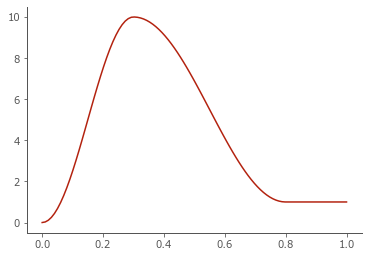

In [11]:
f = combine_scheds([.3, .5, .2], [SchedCos(0,10), SchedCos(10,1), SchedNo(1,1)])
p = torch.linspace(0.,1,100)
plt.plot(p,[f(o) for o in p])

In [13]:
from fastai2.callback.tensorboard import TensorBoardCallback

# def params(m):
#     "Return all parameters of `m`"
#     return [p for p in m.parameters()]

# def  _split(m): return L(m.encoder, m.fc).map(params)

scheds = {'kl_weight': f}

class AnnealedLossCallback(Callback):
    def after_pred(self):
        kl = self.learn.pred[0].new(1)
        kl[0] = self.opt.hypers[0]['kl_weight']
        self.learn.pred = self.learn.pred + (kl,)
        
class DelayedEarlyStoppingCallback(EarlyStoppingCallback):
    def after_epoch(self):
        if(self.pct_train > .6):
            super().after_epoch()
        
model = VAE(image_channels=1, h_dim=196, z_dim=128).cuda()

# shutil.rmtree('logs')
# DelayedEarlyStoppingCallback(patience=5, monitor='kld')
learn = Learner(dls, model, cbs=[ParamScheduler(scheds), AnnealedLossCallback(), ShowGraphCallback()], loss_func=loss_fn, metrics=[BCEMetric(), KLDMetric(), MUMetric(), StdMetric()])
# learn = learn.to_fp16()

epoch,train_loss,valid_loss,bce,kld,mu,std,time
0,49240.941406,46473.011719,45862.12,23229.787,-0.11116075,0.4659131,01:37
1,32856.019531,31489.925781,38177.89,24235.482,-0.07615657,0.3506731,01:37
2,23071.173828,22240.945312,32334.13,23640.676,-0.05621188,0.30639923,01:36
3,19643.550781,19296.556641,28576.373,21871.174,-0.044826448,0.30322415,01:37
4,18412.857422,18176.861328,26059.752,19857.637,-0.039370596,0.3239451,01:45
5,17642.796875,17483.023438,24228.111,18077.496,-0.03681837,0.35526928,01:40
6,17266.500000,17082.734375,22812.256,16614.672,-0.0350689,0.38875282,01:38
7,17159.984375,17052.056641,21714.535,15364.035,-0.03324466,0.4219596,01:43
8,17305.464844,17164.544922,20832.115,14314.728,-0.0316113,0.45238984,01:38
9,17846.162109,17905.111328,20227.768,13322.954,-0.030040152,0.4841605,01:39


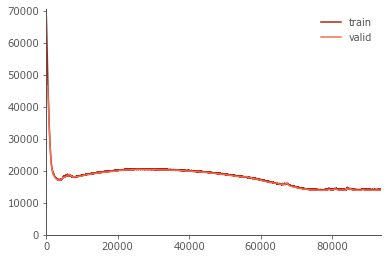

In [14]:
learn.fit_one_cycle(200)

learn.save(datetime.now().strftime('%Y-%m-%d %Hh%M.%S') + '.model')

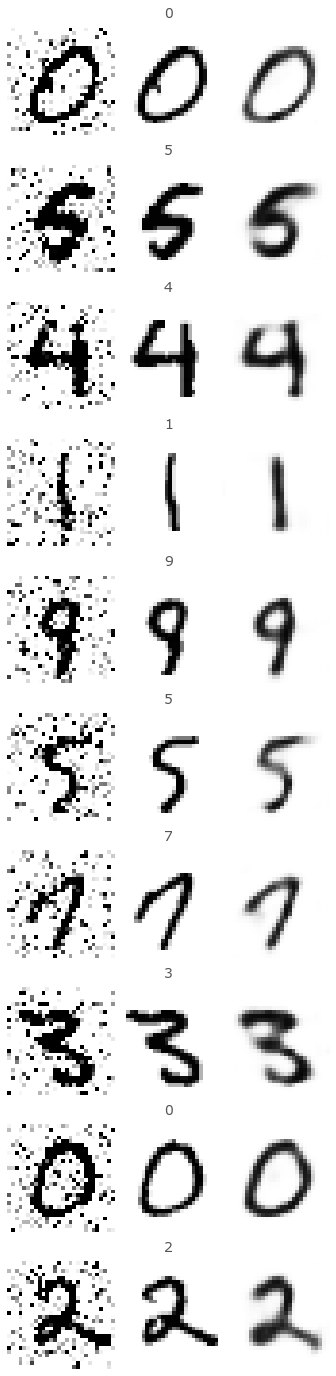

In [20]:
b = learn.dls[0].one_batch()
input_img, nums, targets = to_detach(b)
preds, targs = learn.get_preds(dl=[b])
imgs, _, _, _ = preds

_, axes = plt.subplots(ncols=1, nrows=10, constrained_layout=True, figsize=(10, 19))
i = 0
for a in axes:
    a.set_title(nums[i].cpu().item())
    img = torch.cat([TensorBase(input_img.clamp(0,1)), TensorBase(targs), imgs], dim=3)[i].squeeze(0).cpu()
    a.imshow(img, cmap='Greys')
    a.axis('off')
    i = i + 1

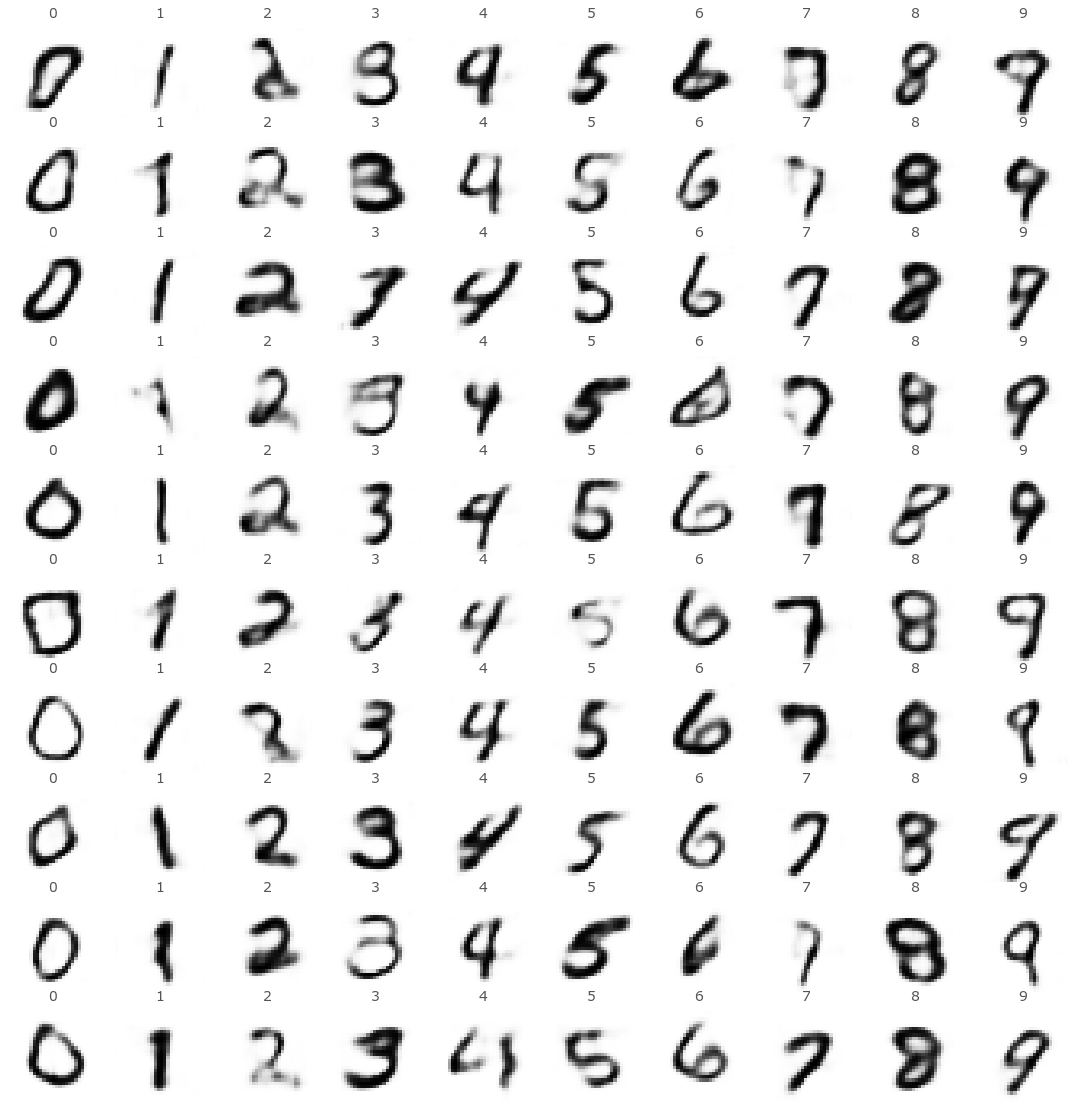

In [16]:
# %debug
num = 10 if url == URLs.MNIST else 2
_, axes = plt.subplots(ncols=num, nrows=10, figsize=(19,19))
learn.model.eval()
i = 0
with torch.no_grad():
    for row in axes:
        z = torch.empty([num,128]).normal_().cuda()
        img = learn.model.decode(z, torch.Tensor(range(num)).long().cuda()).detach().cpu()
        for ax in row:
            ax.imshow(img[i%num][0], cmap='Greys')
            ax.axis('off')
            ax.set_title(str(i%num))
            i += 1

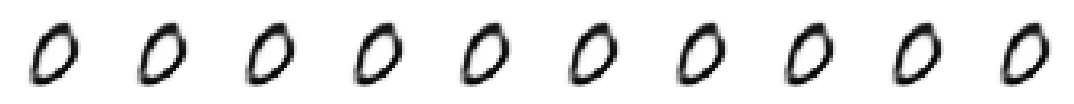

In [19]:
# %debug
_, axes = plt.subplots(ncols=10, nrows=1, figsize=(19,19))
space = np.linspace(0,1,10)
i = 0
with torch.no_grad():
    z = torch.empty([1,128]).normal_().cuda()
    for ax in axes:
        z[0][6] = space[i]
        img = learn.model.decode(z, torch.Tensor([0]).long().cuda()).detach().cpu()
        ax.imshow(img[0][0], cmap='Greys')
        ax.axis('off')
        i += 1

In [60]:
learn.save('vae')

In [15]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.AvgPool2d(2, 2)
        
        ## decoder layers ##
        self.u_conv1 = nn.Conv2d(4, 16, 3, padding=1)
        self.u_conv2 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        
        
        ## decode ##
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `upsample` in some PyTorch versions
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.u_conv1(x))
        # upsample again, output should have a sigmoid applied
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.sigmoid(self.u_conv2(x))
                
        return x

# initialize the NN
# model = ConvAutoencoder()

In [122]:
import torch
from torch import nn
from torch.autograd import Variable

import numpy as np
representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 5
n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(input_size, 200)
        self.en_mu = nn.Linear(200, representation_size)
        self.en_std = nn.Linear(200, representation_size)
        self.de1 = nn.Linear(representation_size, 200)
        self.de2 = nn.Linear(200, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """Encode a batch of samples, and return posterior parameters for each point."""
        h1 = self.relu(self.en1(x))
        return self.en_mu(h1), self.en_std(h1)
    
    def decode(self, z):
        """Decode a batch of latent variables"""
        
        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))
    
    def reparam(self, mu, logvar):
        """Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation."""
        
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
            
    
    def forward(self, x):
        """Takes a batch of samples, encodes them, and then decodes them again to compare."""
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar):
        """ELBO assuming entries of x are binary variables, with closed form KLD."""
        
        set_trace()
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size

        return bce + KLD
    
    def get_z(self, x):
        """Encode a batch of data points, x, into their z representations."""
        
        mu, logvar = self.encode(x.view(-1, input_size))
        return self.reparam(mu, logvar)
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def train(epoch, batches_per_epoch = 501, log_interval=500):
    model.train()
    
    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = model.loss(recon_batch, data, mu, logvar)
        loss.backward()
        #train_loss += loss.data[0]
        optimizer.step()
        if (i % log_interval == 0) and (epoch % 5 ==0):
            #Print progress
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, i * batch_size, batch_size*batches_per_epoch,
                loss.data[0] / len(data)))

    print('====> Epoch: {} done!'.format(
          epoch))


def test(epoch, batches_per_epoch=1):
    model.eval()

    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        recon_batch, mu, logvar = model(data)
        if i == 0:
            n = min(data.size(0), 2)
            print(data.view(batch_size, 2,2)[:n])
            print(recon_batch.view(batch_size, 2,2)[:n])
print_examples = False #Change to true if you want to see some examples at each step!
for epoch in range(1, 30):
    train(epoch)
    if print_examples:
        test(epoch)

> <ipython-input-122-d78c38b6bdb1>(61)loss()
     59 
     60         set_trace()
---> 61         bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
     62         KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
     63         # Normalise by same number of elements as in reconstruction



ipdb>  x.shape


torch.Size([5, 4])


ipdb>  x.view(-1, input_size)


tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]])


ipdb>  x.view(-1, input_size).shape


torch.Size([5, 4])
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> <ipython-input-122-d78c38b6bdb1>(61)loss()
     59 
     60         set_trace()
---> 61         bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
     62         KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
     63         # Normalise by same number of elements as in reconstruction



ipdb>  q


BdbQuit: 